Original resolution of image_good_lighting: 2500 x 2500
Original resolution of image_bad_lighting: 2500 x 2500
Epoch 0/1000
Epoch 10/1000
Epoch 20/1000
Epoch 30/1000
Epoch 40/1000
Epoch 50/1000
Epoch 60/1000
Epoch 70/1000
Epoch 80/1000
Epoch 90/1000
Epoch 100/1000
Epoch 110/1000
Epoch 120/1000
Epoch 130/1000
Epoch 140/1000
Epoch 150/1000
Epoch 160/1000
Epoch 170/1000
Epoch 180/1000
Epoch 190/1000
Epoch 200/1000
Epoch 210/1000
Epoch 220/1000
Epoch 230/1000
Epoch 240/1000
Epoch 250/1000
Epoch 260/1000
Epoch 270/1000
Epoch 280/1000
Epoch 290/1000
Epoch 300/1000
Epoch 310/1000
Epoch 320/1000
Epoch 330/1000
Epoch 340/1000
Epoch 350/1000
Epoch 360/1000
Epoch 370/1000
Epoch 380/1000
Epoch 390/1000
Epoch 400/1000
Epoch 410/1000
Epoch 420/1000
Epoch 430/1000
Epoch 440/1000
Epoch 450/1000
Epoch 460/1000
Epoch 470/1000
Epoch 480/1000
Epoch 490/1000
Epoch 500/1000
Epoch 510/1000
Epoch 520/1000
Epoch 530/1000
Epoch 540/1000
Epoch 550/1000
Epoch 560/1000
Epoch 570/1000
Epoch 580/1000
Epoch 590/1000


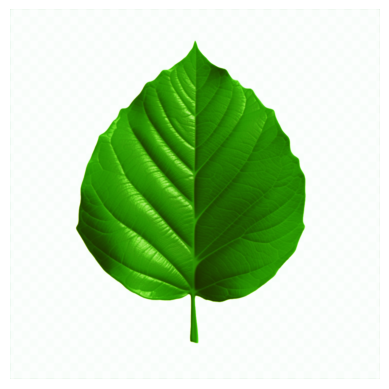

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses
import matplotlib.pyplot as plt

# Define the generator model for higher resolution images
def generator_model(height, width, channels):
    inputs = layers.Input(shape=(height, width, channels))
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    # Add more convolutional layers
    outputs = layers.Conv2D(channels, kernel_size=3, strides=1, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Define the discriminator model for higher resolution images
def discriminator_model(height, width, channels):
    inputs = layers.Input(shape=(height, width, channels))
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    # Add more convolutional layers
    outputs = layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)
    return Model(inputs, outputs)

# Define the generator loss
def generator_loss(fake_output, target_output, generated_output):
    gen_loss = losses.BinaryCrossentropy()(fake_output, tf.ones_like(fake_output))  # Adversarial loss
    content_loss = losses.MeanAbsoluteError()(target_output, generated_output)  # Content loss
    return gen_loss + content_loss

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = losses.BinaryCrossentropy()(real_output, tf.ones_like(real_output))  # Loss for real images
    fake_loss = losses.BinaryCrossentropy()(fake_output, tf.zeros_like(fake_output))  # Loss for fake images
    return real_loss + fake_loss

# Define the training step
@tf.function
def train_step(input_image_real, input_image_fake):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image_fake = generator(input_image_fake, training=True)

        real_output = discriminator(input_image_real, training=True)
        fake_output = discriminator(generated_image_fake, training=True)

        gen_loss = generator_loss(fake_output, input_image_real, generated_image_fake)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Define hyperparameters for higher resolution images
original_height, original_width, original_channels = 1000, 1000, 3  # Original dimensions of input images
epochs = 1000
learning_rate = 0.0002

# Load the two images
image_path_good_lighting = 'good_lighting.jpg'
image_path_bad_lighting = 'bad_lighting.jpg'
image_good_lighting = tf.expand_dims(tf.image.decode_image(tf.io.read_file(image_path_good_lighting)), axis=0)
image_bad_lighting = tf.expand_dims(tf.image.decode_image(tf.io.read_file(image_path_bad_lighting)), axis=0)
original_height_good, original_width_good, _ = image_good_lighting.shape[1], image_good_lighting.shape[2], image_good_lighting.shape[3]
original_height_bad, original_width_bad, _ = image_bad_lighting.shape[1], image_bad_lighting.shape[2], image_bad_lighting.shape[3]

# Print the original resolutions
print("Original resolution of image_good_lighting:", original_height_good, "x", original_width_good)
print("Original resolution of image_bad_lighting:", original_height_bad, "x", original_width_bad)

# Resize images to the original dimensions
target_height, target_width = original_height, original_width
image_good_lighting = tf.image.resize(image_good_lighting, (target_height, target_width))
image_bad_lighting = tf.image.resize(image_bad_lighting, (target_height, target_width))

# Normalize pixel values to range [-1, 1]
image_good_lighting = (tf.cast(image_good_lighting, tf.float32) / 127.5) - 1.0
image_bad_lighting = (tf.cast(image_bad_lighting, tf.float32) / 127.5) - 1.0

# Create generator and discriminator models
generator = generator_model(original_height, original_width, original_channels)
discriminator = discriminator_model(original_height, original_width, original_channels)

# Define optimizers
generator_optimizer = optimizers.Adam(learning_rate)
discriminator_optimizer = optimizers.Adam(learning_rate)

# Training loop
for epoch in range(epochs):
    train_step(image_good_lighting, image_bad_lighting)
    
    # Display training progress
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}')

# Generate an improved image
generated_image_fake = generator(image_bad_lighting, training=False)

# Convert the generated image from [-1, 1] range to [0, 1] range for display
generated_image_fake = (generated_image_fake + 1.0) / 2.0

# Display the generated image
plt.imshow(generated_image_fake[0])
plt.axis('off')
plt.show()
